# Transfer Learning

Inspired by: https://github.com/openai/openai-cookbook/blob/main/examples/Customizing_embeddings.ipynb

In [84]:
# imports
from typing import List, Tuple  # for type hints

import numpy as np  # for manipulating arrays
import pandas as pd  # for manipulating data in dataframes
import pickle  # for saving the embeddings cache
import plotly.express as px  # for plots
import random  # for generating run IDs
from sklearn.model_selection import train_test_split  # for splitting train & test data
import torch  # for matrix optimization

import datasets

from mteb import MTEB

seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)


## 1. Load and process input data

In [85]:
def load_dataset_for_task(task_name: str, split: str = 'train'):
    mteb = MTEB(tasks=[task_name], task_langs=["en"])
    task = mteb.tasks[0]
    task.load_data()
    assert task.data_loaded, "Data was not loaded"
    return task.dataset[split] # Have form train, validation, test (test is used for MTEB)

def process_dataset(dataset: datasets.Dataset) -> pd.DataFrame:
    train_df = dataset.to_pandas()
    train_df = train_df[['sentence1', 'sentence2', 'score']]
    def normalize(x, min_score, max_score): # Normalise between 0 and 1 (Maybe better to do -1 and 1)
        return (x - min_score) / (max_score - min_score)
    train_df['score'] = normalize(train_df['score'], train_df['score'].min(), train_df['score'].max())
    return train_df

In [86]:
task_name = "STSBenchmark"
train_dataset = load_dataset_for_task(task_name, split='train')
val_dataset = load_dataset_for_task(task_name, split='validation')

df_train = process_dataset(train_dataset)
df_val = process_dataset(val_dataset)

df_train.head()

,sentence1,sentence2,score
0,A plane is taking off.,An air plane is taking off.,1.00
1,A man is playing a large flute.,A man is playing a flute.,0.76
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76
3,Three men are playing chess.,Two men are playing chess.,0.52
4,A man is playing the cello.,A man seated is playing the cello.,0.85


## 2. Generate Synthetic Data

In [87]:
# TODO (Look at generating for dismilliar data cause all of them seem to be simialr)

## 3. Get Embeddings and Cosine Similarities

In [88]:
from model_factory import model_factory
model_name = 'voyage'

In [89]:
def generate_embedding(df: pd.DataFrame, model_name: str, task_name: str):
    model = model_factory(model_name, task_name)
    for column in ['sentence1', 'sentence2']:
        df[f"{column}_embedding"] = model.encode(df[column].tolist())

def get_cosine_similarity(a: np.array, b: np.array):
    dot_product = np.dot(a, b)
    norm_a = np.linalg.norm(a)
    norm_b = np.linalg.norm(b)
    return dot_product / (norm_a * norm_b)

def generate_cosine_similarity(df: pd.DataFrame):
    df['cosine_similarity'] = df.apply(lambda x: get_cosine_similarity(x['sentence1_embedding'], x['sentence2_embedding']), axis=1)

In [90]:
generate_embedding(df_train, model_name, task_name)
generate_embedding(df_val, model_name, task_name)

generate_cosine_similarity(df_train)
generate_cosine_similarity(df_val)

df_train.head()

Loading voyage from cache for STSBenchmark...
Loading voyage from cache for STSBenchmark...


,sentence1,sentence2,score,sentence1_embedding,sentence2_embedding,cosine_similarity
0,A plane is taking off.,An air plane is taking off.,1.00,"[-0.009499897180926493, 0.0301658415866585, 0....","[-0.007148529487661709, 0.02677731620228949, 0...",0.989618
1,A man is playing a large flute.,A man is playing a flute.,0.76,"[-0.05704887022457301, 0.062293174230553326, 0...","[-0.06139936930163547, 0.05968738972087921, 0....",0.984086
2,A man is spreading shreded cheese on a pizza.,A man is spreading shredded cheese on an uncoo...,0.76,"[-0.04560167076112835, 0.03845534935758576, 0....","[-0.037441772156281646, 0.03777824410742927, 0...",0.988618
3,Three men are playing chess.,Two men are playing chess.,0.52,"[-0.02487597662154204, 0.03249265444987086, -0...","[-0.02721611720650288, 0.04553748874725227, 0....",0.948362
4,A man is playing the cello.,A man seated is playing the cello.,0.85,"[-0.05514069845318368, 0.04386556755319591, 0....","[-0.06483882233777385, 0.053375318816676315, 0...",0.973424


## 4. Evaluate The Baseline Performance

We use spearman and Pearson to evaluate the performance. 

Pearson correlation is a measure of strength of linear relationship between two variables. It ranges from -1 to 1.

While spearman correlation is a measure of monotonic relationship between two variables. It ranges from -1 to 1.

We want both these values to be close to 1. 


In [91]:
def get_correlation(df: pd.DataFrame):
    return df['cosine_similarity'].corr(df['score'], method='spearman'), df['cosine_similarity'].corr(df['score'], method='pearson')

spearmans, pearsons = get_correlation(df_train)
print(f"Train: Spearman: {spearmans}, Pearson: {pearsons}")

spearmans, pearsons = get_correlation(df_val)
print(f"Validation: Spearman: {spearmans}, Pearson: {pearsons}")

Train: Spearman: 0.8242663753045756, Pearson: 0.840167037989439
Validation: Spearman: 0.8589175713958699, Pearson: 0.8550142024656554


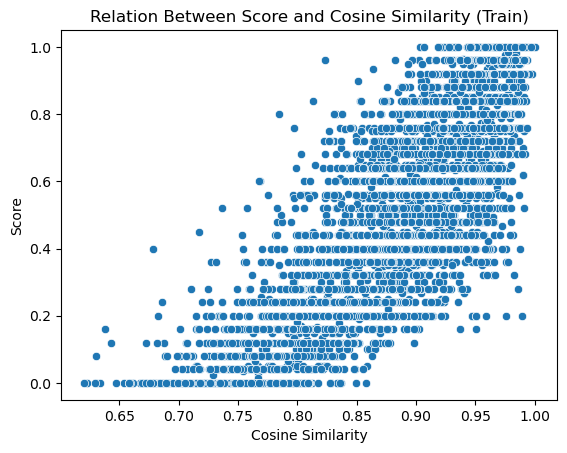

In [92]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_correlation(df: pd.DataFrame, title: str):
    sns.scatterplot(data=df, x='cosine_similarity', y='score')
    plt.title(title)
    plt.xlabel('Cosine Similarity')
    plt.ylabel('Score')
    plt.show()

plot_correlation(df_train, 'Relation Between Score and Cosine Similarity (Train)')